# Tutorial 3: Model tuning

In the second tutorial, we built two inital models for predicting the lead time and measured their performance.
The results were surprising since the more advanced (KNNRegressor) model performed worse on the training data than our baseline (median). You will run into similar situations frequenty in real life projects. In this tutorial we will show you how to proceed. You will learn how to

- Track our experiments
- Rank possible next steps
- Implement some of the potential improvements
- and hopefully get a good understanding of the main [Data Science workflow](https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining)

## Experiment tracking
Before we go back to coding let's take a minute to talk about best non-coding practises. We already tried two different approaches to our problem. Eventually, you will probably try out many more. It can be very easy to lose the overview of all the things you tried, what worked and what didn't. We need to start keeping track of our experiments. For starters, a simple excel file is enough. 

For each experiment, you should write down
- an ID: A unique identifier that can be used as a reference
- the dataset you used for training and testing
- all the data preprocessing you did (e.g. replacing NaNs with 'Start'/'End')
- how the data was split between train and test (in our case, the seperation date is essential)
- the algorithm and hyperparameter settings 
- the results on train and test
- where to find the code (preferably a link to a tagged git repo)
- any comments that are noteworthy

In our case, we could note:

| ID | Data | Pre | Seperation Date | Algorithm | RMSLE Train | RMSLE Test | Code | Comments |
|---|---|---|---|---|---|---|---|---|
| 0 | gdsc2_public.csv | Standard | 01.01.2018 | Median | 1.62 | 2.10 | [Link](http://de-mucingode1/gitlab/dkuehlwein/global_data_science_challenge_2_public/tags/Baselines) | Baseline |
| 1 | gdsc2_public.csv | One-Hot-Encoding of 'work_type', 'work_priority' | 01.01.2018 | KNNRegressor (Default) | 1.99 | 1.49 | [Link](http://de-mucingode1/gitlab/dkuehlwein/global_data_science_challenge_2_public/tags/Baselines) | Performs worse than baseline on training. Model is not complex enough, need to check train/test split | 

## Next steps
To proritize our next steps, we write down all options and rank them by difficulty and expected benefit. A [Kanban board](http://de-mucingode1/gitlab/dkuehlwein/global_data_science_challenge_2_public/boards) simplifies the process. For this demo we will use a simple table

| Id | Short Description | Detailed Description | Difficulty | Benefit |
|---|---|---|---|---|
| 0 | Train/Test dataset | Check if the distributions of train and test data are similar. Reuse the work from tutorial 1 | medium | high |
| 1 | Improve features | Add additional features. Reuse the work from tutorial 2 | easy | high |
| 2 | Improve hyperparameters | Change hyperparamters. Reuse the work from tutorial 2 | high | medium |
| 3 | New model class | Change the class of the model. Reuse the work from tutorial 2 | medium | high |

We start with task 1 because it should be easy and has a high expected benefit. A few notes on the estimates:
- Task 0 is an additional EDA. EDAs can become quite complex, hence we estimate medium difficulty.
- Task 1 could actually range from easy to hard, depending on how we change the features. However, just adding additional one-hot encodings is very easy (it was an exercise) and we will start with that.
-  Doing task 2 for only a single hyperparameter would be easy, but to do it properly, we'd have to set up a grid/random search on all possible parameters. Doing this manually is a lot of work, setting up a framework like automl to do it for us is as well.
- If we use one of the default scikit-learn models, task 3 is very easy. If we use a non-scikit-learn model we might run into trouble installing and setting up new packages. We might also have to do some feature preprocessing since different models have different requirements. 


## Adding additional features (Task 1)
We start by reusing some of our old code. By now you should see the value of refacotoring code into separate function.

In [1]:
import datetime as dt
import shap
import matplotlib.pyplot as plt
import pandas as pd
import sys
from IPython.display import display
from ipywidgets import interactive
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
sys.path.append('..') 
from src.data_preparation import compute_work_item_times, split_times
from src.evaluate import rmsle
from src.visualizations import plot_tree, plot_open_and_closed_tickets
%matplotlib inline
plt.style.use('fivethirtyeight')

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

In [5]:
file_path='../data/gdsc2_public.csv'
df = pd.read_csv(file_path, sep=';', parse_dates=['timestamp'])
df.from_phase.fillna('Start', inplace=True)  
df.to_phase.fillna('End', inplace=True)
df.components.fillna('', inplace=True)

In [6]:
sep_date_str = '01.01.2018'
times = compute_work_item_times(df)
train_times, test_times, closed_times, open_times = split_times(times, sep_date_str)

train_work_items = set(train_times.work_item)  
test_work_items = set(test_times.work_item)  
df_start_only = df[df.from_phase == 'Start']
train_df = df_start_only[df_start_only.work_item.isin(train_work_items)]  
test_df = df_start_only[df_start_only.work_item.isin(test_work_items)]

df[df.work_item == 'WI_000001']

,timestamp,work_item,work_type,work_priority,domain,platform,components,from_phase,to_phase,from_resource,to_resource
0,2015-01-02 14:39:14,WI_000001,WT_00001,WP_00003,BD_00001,PL_00001,,Start,Analyze,NaN,ER_00043
24,2015-01-05 11:48:08,WI_000001,WT_00001,WP_00003,BD_00001,PL_00001,,Analyze,Design,ER_00043,ER_00149
29,2015-01-05 12:35:59,WI_000001,WT_00001,WP_00003,BD_00001,PL_00001,,Design,Analyze,ER_00149,ER_00149
140,2015-01-07 11:04:51,WI_000001,WT_00001,WP_00003,BD_00001,PL_00001,,Analyze,Design,ER_00149,ER_00043
145,2015-01-07 14:04:44,WI_000001,WT_00001,WP_00003,BD_00001,PL_00001,,Design,Analyze,ER_00043,ER_00149
146,2015-01-07 14:07:56,WI_000001,WT_00001,WP_00003,BD_00001,PL_00001,,Analyze,Design,ER_00149,ER_00043
149,2015-01-07 14:37:35,WI_000001,WT_00001,WP_00003,BD_00001,PL_00001,,Design,Build,ER_00043,ER_00149
333,2015-01-13 10:25:36,WI_000001,WT_00001,WP_00003,BD_00001,PL_00001,,Build,Test,ER_00149,ER_00058
473,2015-01-15 11:04:02,WI_000001,WT_00001,WP_00003,BD_00001,PL_00001,,Test,Package,ER_00058,ER_00149
591,2015-01-19 08:54:54,WI_000001,WT_00001,WP_00003,BD_00001,PL_00001,,Package,Accept,ER_00149,ER_00149


Previously, we only used the *work_type* and *work_priority* columns. But there is a lot more information we can add:

- The *domain* column is a categorical variable. We could include this via a One-Hot-Encoding.
- The *platform* column is also a categorical variable. We could include this via a One-Hot-Encoding.
- The *components* column could be another categorical variable. 
- The *from_phase* and *to_phase* columns contain information about the what already happened (How many phases, which phases, how long) to the work item. Encoding this as a feature will require some thought.
- The *from_resource* and *to_resouce* columns contain a lot of info. Maybe some workers are faster than others. Maybe some components can only be solved by specific resources. There could also be too few resources which leads to delay. Determining which of these points is relevant and encoding the relevant information into features is a nontrivial task.

Because this is a beginners tutorial, we will start by adding features for the *domain* and *platform* columns.

In [7]:
onehotencoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
# There will be components that only appear in the test set. To deal with this, we change the handle_unknown flag.
cols_to_encode = ['work_type', 'work_priority', 'domain', 'platform']
train_features = onehotencoder.fit_transform(train_df[cols_to_encode])
test_features = onehotencoder.transform(test_df[cols_to_encode])  

In [8]:
model = KNeighborsRegressor()
model.fit(train_features, train_times.duration_in_days)
train_predictions = pd.DataFrame(train_times.work_item)  
train_predictions['predictions'] = model.predict(train_features)
test_predictions = pd.DataFrame(test_times.work_item)
test_predictions['predictions'] = model.predict(test_features)
print(rmsle(train_times, train_predictions))
print(rmsle(test_times, test_predictions))

1.8426599070167957
1.4956035595471975


We improved on the training data but not on the test data. Let's also add features for the *components* column and creating a separate function for the evalation

In [9]:
def eval_model(model, train_features, train_times, test_features, test_times):
    model.fit(train_features, train_times.duration_in_days)
    train_predictions = pd.DataFrame(train_times.work_item)  
    train_predictions['predictions'] = model.predict(train_features)
    test_predictions = pd.DataFrame(test_times.work_item)
    test_predictions['predictions'] = model.predict(test_features)
    train_rmsle = rmsle(train_times, train_predictions)
    test_rmsle = rmsle(test_times, test_predictions)
    return train_rmsle, test_rmsle

**Exercise:** Refactor this code into a function that you can import ala 
```python
from src.evaluate import eval_model
```

In [10]:
onehotencoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
# There will be components that only appear in the test set. To deal with this, we change the handle_unknown flag.
cols_to_encode = ['work_type', 'work_priority', 'domain', 'platform', 'components']
train_features = onehotencoder.fit_transform(train_df[cols_to_encode])
test_features = onehotencoder.transform(test_df[cols_to_encode])  

In [11]:
model = KNeighborsRegressor()
eval_model(model, train_features, train_times, test_features, test_times)

(1.6774949916703508, 1.5683950715535333)

A big improvement on the training data, but we got worse on the test data.

**Exercise:** A business user tells you that there are many tickets that are just forgotten and not touched any more. How would you encode this information to make available to the algorithm?

| ID | Data | Pre | Seperation Date | Algorithm | RMSLE Train | RMSLE Test | Code | Comments |
|---|---|---|---|---|---|---|---|---|
| 0 | gdsc2_public.csv | Standard | 01.01.2018 | Median | 1.62 | 2.10 | [Link](http://de-mucingode1/gitlab/dkuehlwein/global_data_science_challenge_2_public/tags/Baselines) | Baseline |
| 1 | gdsc2_public.csv | One-Hot-Encoding of 'work_type', 'work_priority' | 01.01.2018 | KNNRegressor (Default) | 1.99 | 1.49 | [Link](http://de-mucingode1/gitlab/dkuehlwein/global_data_science_challenge_2_public/tags/Baselines) | Performs worse than baseline on training. Model is not complex enough, need to check train/test split | 
| 2 | gdsc2_public.csv | One-Hot-Encoding of 'work_type', 'work_priority', 'domain', 'platform' | 01.01.2018 | KNNRegressor (Default) | 1.84 | 1.50 | [Link](http://de-mucingode1/gitlab/dkuehlwein/global_data_science_challenge_2_public/tags/Baselines) | Good improvement on train. No change for test | 
| 3 | gdsc2_public.csv | One-Hot-Encoding of 'work_type', 'work_priority', 'domain', 'platform', 'components' | 01.01.2018 | KNNRegressor (Default) | 1.68 | 1.57 | [Link](http://de-mucingode1/gitlab/dkuehlwein/global_data_science_challenge_2_public/tags/Baselines) | Good improvement on train, test got worse. | 

As discussed above, there is still a lot more information we could add that could be helpful for the predictions, e.g.

- Which resource is working on a ticket
- The history of the ticket (e.g. how many phase changes)
- Was somebody currently working on the ticket, or has it been dormant for a long time
- What is the current workoad of the system? Or there other open tickets that have a higher priority?

It is up to you to figure out if it is worthwhile to use this information and how to encode it. We update our tasks with these new ideas:

| Id | Short Description | Detailed Description | Difficulty | Benefit |
|---|---|---|---|---|
| 0 | Train/Test dataset | Check if the distributions of train and test data are similar. Reuse the work from tutorial 1 | medium | high |
| 2 | Improve hyperparameters | Change hyperparamters. Reuse the work from tutorial 2 | high | medium |
| 3 | New model class | Change the class of the model. Reuse the work from tutorial 2 | medium | high |
| 4 | Add resource info to features | Resource availabilty and previous workers | high | low |
| 5 | Add item history to features | How many phase changes | high | medium |
| 6 | Add activity info to features | How recently somebody has worked on the ticket. | high | medium |
| 7 | Add system status to features | How many other tickets with which priorities, etc are currently in the system. | high | medium |

The benefit estimates for tasks 4-7 are very rough. We should talk to the client and do an EDA to improve them.

## Predicting with a new model class (Task 3)
The KNNRegressor model has two big drawbacks (unless we change the metric):
- every feature is equally important
- it is easily influenced by outliers

Decision Tree / Random Forest do not share these problems. (Instead, they are more likely to overfit and struggle when there are many features). Let's see how a Random Forest model performs on our problem. We choose the XGBoost Random Forest implementation for our experiment. As a rule of thumb, unless you're dealing with a deep learning problem, XGBoost is very likely the [best algorithm](https://www.kdnuggets.com/2015/12/harasymiv-lessons-kaggle-machine-learning.html).

In [12]:
model = XGBRegressor()
eval_model(model, train_features, train_times, test_features, test_times)

C:\Users\bhavrang\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\bhavrang\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


(1.764577435636904, 1.250806711915415)

This is a huge improvement over our previous best result!

| ID | Data | Pre | Seperation Date | Algorithm | RMSLE Train | RMSLE Test | Code | Comments |
|---|---|---|---|---|---|---|---|---|
| 0 | gdsc2_public.csv | Standard | 01.01.2018 | Median | 1.62 | 2.10 | [Link](http://de-mucingode1/gitlab/dkuehlwein/global_data_science_challenge_2_public/tags/Baselines) | Baseline |
| 1 | gdsc2_public.csv | One-Hot-Encoding of 'work_type', 'work_priority' | 01.01.2018 | KNNRegressor (Default) | 1.99 | 1.49 | [Link](http://de-mucingode1/gitlab/dkuehlwein/global_data_science_challenge_2_public/tags/Baselines) | Performs worse than baseline on training. Model is not complex enough, need to check train/test split | 
| 2 | gdsc2_public.csv | One-Hot-Encoding of 'work_type', 'work_priority', 'domain', 'platform' | 01.01.2018 | KNNRegressor (Default) | 1.84 | 1.50 | [Link](http://de-mucingode1/gitlab/dkuehlwein/global_data_science_challenge_2_public/tags/Baselines) | Good improvement on train. No change for test | 
| 3 | gdsc2_public.csv | One-Hot-Encoding of 'work_type', 'work_priority', 'domain', 'platform', 'components' | 01.01.2018 | KNNRegressor (Default) | 1.68 | 1.57 | [Link](http://de-mucingode1/gitlab/dkuehlwein/global_data_science_challenge_2_public/tags/Baselines) | Good improvement on train, test got worse. | 
| 4 | gdsc2_public.csv | One-Hot-Encoding of 'work_type', 'work_priority', 'domain', 'platform', 'componentss' | 01.01.2018 | XGBRegressor (Default) | 1.76 | 1.25 | [Link](http://de-mucingode1/gitlab/dkuehlwein/global_data_science_challenge_2_public/tags/Baselines) | Big improvement over KNN! | 

Note how easy it is to change the model class!

**Exercise:** Try out different regression algorithm. Check the [sklearn library](https://scikit-learn.org/stable/supervised_learning.html) for ideas.

## Hyperparameter tuning (Task 2)
Even though proper hyperparamter tuning can be very complex we will introduce the basic ideas.
We will use a DecisionTreeRegressor, mainly because they make it very easy to see the effect of hyperparameters.
We start with the default model.

In [13]:
model = DecisionTreeRegressor()
eval_model(model, train_features, train_times, test_features, test_times)

(1.501317881507182, 1.6631083621677474)

The performance on the training data is considerably better than the performance on the test data. Given our previous experiments this is an indicator that we are overfitting quite a bit. Hyperparameters are a way to combat this.
Check the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor) for a description of all the available options.

In [14]:
model = DecisionTreeRegressor(max_depth=5)
eval_model(model, train_features, train_times, test_features, test_times)

(1.810501237293107, 1.297310810385968)

Restricting the maximum depth reduces the flexibility of the model, and hence also the potential for overfitting. Just by changing one paramter, we changed a very bad model to one that is almost competitive to the current best result!

**Hyperparamters and features can have a major impact on your results. Don't dismiss a model class just because the default version performs badly.**

The visualization allows easy changing of the hyperparamters and the effect thereof. Note how the both the complexity and the values for the MSE (*Mean Square Error*) change.

In [15]:
feature_names = onehotencoder.get_feature_names()
train_target = train_times.duration_in_days
plot_tree_partial = lambda split, depth, min_split, min_leaf: plot_tree(train_features, train_target, feature_names, split, depth, min_split, min_leaf)

inter = interactive(plot_tree_partial, 
                    split = ["best", "random"], 
                    depth=[1,2,3,4], 
                    min_split=(0.1,1), 
                    min_leaf=(0.1,0.5))
display(inter)

interactive(children=(Dropdown(description='split', options=('best', 'random'), value='best'), Dropdown(descri…

You might wonder where the complexity of hyperparamter tuning comes in. The challenge is to keep track of all the combinations you tried. Unless you use an [existing library](https://github.com/automl/auto-sklearn) or an external tool like DataRobot, your best bet is to create a framework that generates different hyperparameter combination through random sampling and automatically stores the settings and results.

**Exercise:** Update the experiment and task table.

## Rolling forecast (Task 0)
In our experiments so far, we often had the case that the error in the training data was higher than on the test data.
This could be due to differencen in the distribution. A quick check of the durations shows that this is indeed the case.

In [16]:
train_times.duration_in_days.describe()

count    9290.000000
mean       51.641849
std        90.441897
min         0.000000
25%         4.742500
50%        17.735000
75%        57.152500
max      1017.650000
Name: duration_in_days, dtype: float64

In [17]:
test_times.duration_in_days.describe()

count     548.000000
mean      192.532920
std       215.038193
min        11.830000
25%        65.710000
50%       107.410000
75%       230.862500
max      1112.920000
Name: duration_in_days, dtype: float64

There are huge differences between the two datasets. This indicates that the results we got on our test data are not reliable. How to proceed? Let us reconsider the open and closed ticket numbers:

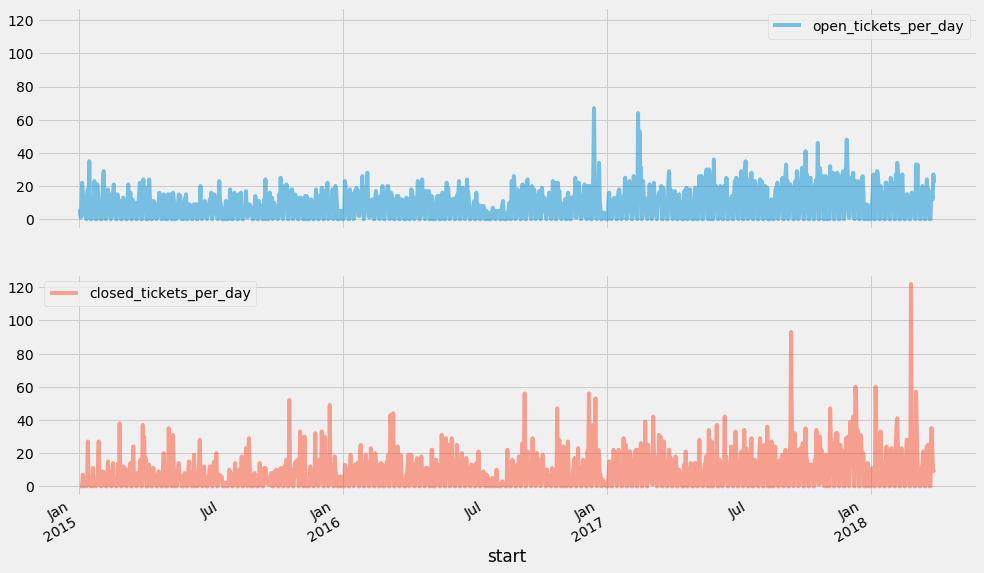

In [18]:
plot_open_and_closed_tickets(times)

Looking back at the open and closed tickets per day, we can see some unique events. The peaks and the end of 2017 and beginning of 2018 are probably due to some special effort and will be hard, if not impossible to predict. After all, we can only learn patterns, not unique events.

Outlier/Unique event removal and stratification of the data could be a solution, but we will leave that as an exercise. Instead, we will introduce a better method for time series prediction: the rolling forcast. So far, we only measured the results for a single day, the separation date. A rolling forcasts evaluates the model on every single day. I.e. we compute the results for every reasonable separation date and aggregate the results.

In [19]:
start_date = dt.datetime.strptime('01.01.2017', '%d.%m.%Y')
end_date = dt.datetime.strptime('01.01.2018', '%d.%m.%Y')
daterange = pd.date_range(start_date, end_date)

df_start_only = df[df.from_phase == 'Start']
model = DecisionTreeRegressor(max_depth=5)

train_results = []
test_results = []

for sep_date in daterange:
    sep_date_str = sep_date.strftime("%d.%m.%Y")  # Format the sep_date to the right form
    print('Evaluating performance for separation day %s' % sep_date_str)
    
    # Create train and test datasets
    train_times, test_times, closed_times, open_times = split_times(times, sep_date_str)
    train_work_items = set(train_times.work_item)  
    test_work_items = set(test_times.work_item)  
    train_df = df_start_only[df_start_only.work_item.isin(train_work_items)]  
    test_df = df_start_only[df_start_only.work_item.isin(test_work_items)]
    
    # Encode the featurs
    onehotencoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    cols_to_encode = ['work_type', 'work_priority', 'domain', 'platform']
    train_features = onehotencoder.fit_transform(train_df[cols_to_encode])
    test_features = onehotencoder.transform(test_df[cols_to_encode])  

    # Evaluate the model
    train_rmsle, test_rmsle = eval_model(model, train_features, train_times, test_features, test_times)
    train_results.append(train_rmsle)
    test_results.append(test_rmsle)

Evaluating performance for separation day 01.01.2017
Evaluating performance for separation day 02.01.2017
Evaluating performance for separation day 03.01.2017
Evaluating performance for separation day 04.01.2017
Evaluating performance for separation day 05.01.2017
Evaluating performance for separation day 06.01.2017
Evaluating performance for separation day 07.01.2017
Evaluating performance for separation day 08.01.2017
Evaluating performance for separation day 09.01.2017
Evaluating performance for separation day 10.01.2017
Evaluating performance for separation day 11.01.2017
Evaluating performance for separation day 12.01.2017
Evaluating performance for separation day 13.01.2017
Evaluating performance for separation day 14.01.2017
Evaluating performance for separation day 15.01.2017
Evaluating performance for separation day 16.01.2017
Evaluating performance for separation day 17.01.2017
Evaluating performance for separation day 18.01.2017
Evaluating performance for separation day 19.0

Evaluating performance for separation day 05.11.2017
Evaluating performance for separation day 06.11.2017
Evaluating performance for separation day 07.11.2017
Evaluating performance for separation day 08.11.2017
Evaluating performance for separation day 09.11.2017
Evaluating performance for separation day 10.11.2017
Evaluating performance for separation day 11.11.2017
Evaluating performance for separation day 12.11.2017
Evaluating performance for separation day 13.11.2017
Evaluating performance for separation day 14.11.2017
Evaluating performance for separation day 15.11.2017
Evaluating performance for separation day 16.11.2017
Evaluating performance for separation day 17.11.2017
Evaluating performance for separation day 18.11.2017
Evaluating performance for separation day 19.11.2017
Evaluating performance for separation day 20.11.2017
Evaluating performance for separation day 21.11.2017
Evaluating performance for separation day 22.11.2017
Evaluating performance for separation day 23.1

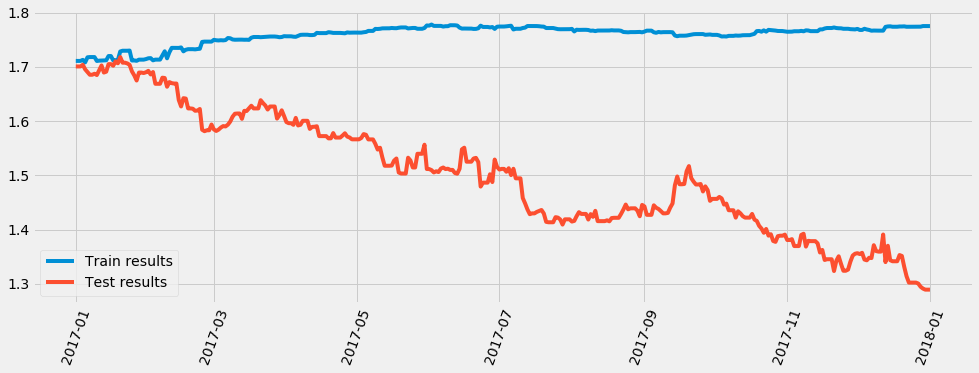

In [20]:
plt.figure(figsize=(15,5))
plt.plot(daterange, train_results, label='Train results')
plt.plot(daterange, test_results, label='Test results')
plt.xticks(rotation=70)
plt.legend()

A rolling forecast gives us a much better idea of the overall performance of our model. We can see that our model gets better over time. It seems that also in this case, more data relates with better results.

*Note:* If you use an XGBRegressor, you'll see that there is an issue with the rmlse computation. There are some cases where the model predicts negative values. Of course this doesn't make sense, so you will need to find a way to fix this.

**Exercise:** 
- Find a solution for the negative duration predictions.
- How would you incorperate these results in the experiment table? (Hint: Think of a way of aggregating the indivual rmlse values)
- Run the rolling forecast for a longer time. Do the results change? 
- What happends if you try a different model type?

## Bonus: Understanding the model
SHAP (SHapley Additive exPlanation) is a tool which explains the influence of each feature for the prediction.
In SHAP you can use different types of presentation. In this example we use the force_plot and summary_plot to illustrate the explanation of the results of XGBoost. The code and more explanations can be found [here](https://github.com/slundberg/shap).

In [21]:
shap.initjs()  # load JS visualization code to notebook
explainer = shap.TreeExplainer(model)  # explain the model's predictions using SHAP values
shap_values = explainer.shap_values(train_features)

C extension was not built during install!


ImportError: numpy.core.multiarray failed to import

A force plots illustrates the effect of the indiviual features to an individual prediction.

In [22]:
feature_names = onehotencoder.get_feature_names()
prediction_id = 0
shap.force_plot(explainer.expected_value, 
                shap_values[prediction_id,:], 
                train_features[prediction_id], 
                feature_names=feature_names)

NameError: name 'explainer' is not defined

A summary plots shows the features importance over the complete dataset.

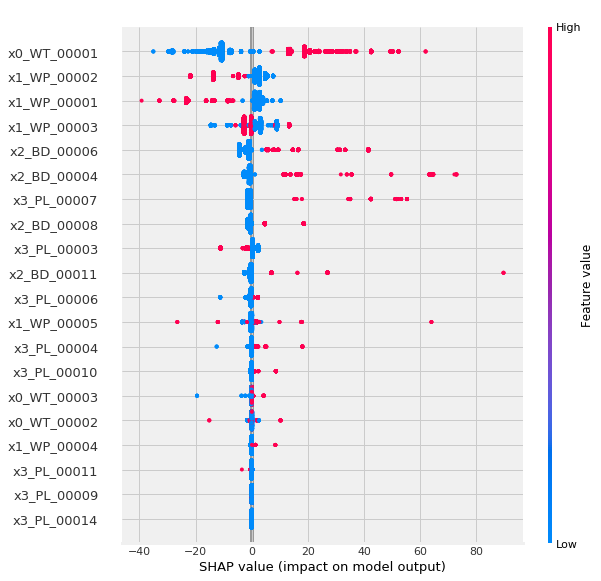

In [20]:
shap.summary_plot(shap_values, train_features, feature_names=feature_names)

## Conclusion
This concludes the third and last tutorial. We covered

- How to structure a Data Science projects
- How to improve your predictions with better models and hyperparameters
- How the create a more meaningful evaluation
- How to visualize the impact of the features on individual predictions

With this knowledge you are ready to go on on your own. Build the best model and submit your results to our [server](http://10.41.72.110:8000/scoreboard_test/) to see how you fare against the other teams!